In [453]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)


In [454]:
train = pd.read_csv('train.csv', index_col=0, encoding='utf-8')

In [455]:
test = pd.read_csv('test.csv', index_col=0, encoding='utf-8')

In [456]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [457]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [458]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [459]:
train.shape, test.shape

((10000, 19), (5000, 18))

In [460]:
#проверяем, какие типы нужно изменить
train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [461]:
#заменим категориальные признаки
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})
test[feature_bin_names] = test[feature_bin_names].replace({'A':0, 'B':1})

In [462]:
train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [463]:
#обработка пропусков
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] =     train['Square'] - train['KitchenSquare']
test.loc[test['LifeSquare'].isna(), 'LifeSquare'] =     test['Square'] - test['KitchenSquare']

In [464]:
train['Healthcare_1'].fillna(train['Healthcare_1'].median(), inplace=True)
test['Healthcare_1'].fillna(test['Healthcare_1'].median(), inplace=True)

In [465]:
#проверка, все ли значения количества комнат целочисленные
train.loc[(train['Rooms'] //1 - train['Rooms'] )!=0, 'Rooms']

Series([], Name: Rooms, dtype: float64)

In [466]:
#обработка выбросов
train['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

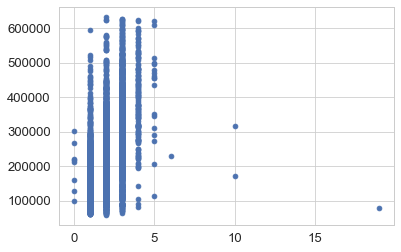

In [467]:
plt.scatter(train['Rooms'], train['Price']);

In [468]:
test['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

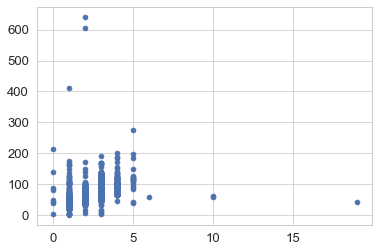

In [469]:
plt.scatter(train['Rooms'], train['Square']);

In [470]:
train['Rooms'].mode()

0   2.00
dtype: float64

In [477]:
# замена выбросов
train.loc[(train['Rooms'] > 5)|(train['Rooms'] == 0), 'Rooms'] = train['Rooms'].mode()[0]
test.loc[(test['Rooms'] > 5)|(test['Rooms'] == 0), 'Rooms'] = train['Rooms'].mode()[0] 


train.loc[(train['Square'] > 400) | (train['Square'] < 10), 'Square'] = train['Square'].median()
test.loc[(test['Square'] > 400) | (test['Square'] < 10), 'Square'] =  train['Square'].median()
#.median()
train.loc[(train['LifeSquare'] > 400), 'LifeSquare'] =  train['LifeSquare'].median()
test.loc[(test['LifeSquare'] > 400), 'LifeSquare'] = train['LifeSquare'].median()

In [478]:
target_name = ['Price']
#после построения модели, просмотрела feature_importances_ и исключила наименее значимые
feature_names = [
'DistrictId',
             'Rooms',
             'Square',
'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
           # 'Ecology_2',
          #  'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Helthcare_2',
             'Shops_1'
           #  'Shops_2'



                ]

In [479]:
X = train[feature_names]
y = train[target_name]

X_test = test[feature_names]


In [480]:
# комментирую GridSearchCV, чтобы не замедлять работу проекта
#forest = RandomForestRegressor(max_depth=19, 
#                               max_features=6, 
#                               n_estimators=100,
#                              random_state=42)
#params = {
#    'n_estimators': [400],
#  'max_depth': [18,19,20],
#   'max_features': [5,6,7]
#}
#forest_grid = GridSearchCV(forest, params, scoring='r2', 
#                 cv=KFold(n_splits=10, random_state=42, shuffle=True), 
#                n_jobs=-1)
#forest_grid.fit(X, y)
#print(forest_grid.best_params_)
#print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

In [481]:
#forest_best = forest_grid.best_estimator_
#importances = forest_best.feature_importances_
#feat_importances = pd.Series(importances, index=feature_names)
#feat_importances.sort_values(ascending=True, inplace=True)

In [482]:
#feat_importances.plot(kind='barh', figsize=(10, 6));

In [483]:
#строим лес с лучшими параметрами
my_forest = RandomForestRegressor(max_depth=18, 
                              max_features=5, 
                               n_estimators=400,
                               random_state=42)
my_forest.fit(X, y)

y_pred = my_forest.predict(X_test)

In [484]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.to_csv('JuliaGribova_predictions.csv', index=False)

In [485]:
#пробовала Градиентный метод, но он дал худший результат, поэтому его закомментировала
#gb_model = GradientBoostingRegressor(random_state=42)
#params = {'n_estimators':[100, 200, 400], 
 #         'max_depth':[5, 7, 9]}

#gs = GridSearchCV(gb_model, params, scoring='r2', 
 #                 cv=KFold(n_splits=3, random_state=42, shuffle=True), 
#                  n_jobs=-1)
#gs.fit(X, y)
#gs.best_params_

In [486]:
#final_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
#final_model.fit(X, y)
#y_pred = final_model.predict(X_test)


In [487]:
#preds = pd.DataFrame()
#preds['Id'] = X_test.index
#preds['Price'] = y_pred
#preds.to_csv('JuliaGribova_predictions_grad.csv', index=False)